# Face recognition using k-Nearest Neighbor

---

### Contents
<ol>
    <li><a href="#data-preprocessing" style="color: currentColor">Data preprocessing</a></li>
    <li><a href="#pca" style="color: currentColor">Principal Component Analysis</a></li>
    <li><a href="#knn" style="color: currentColor">k-Nearest-Neighbor</a></li>
    <li><a href="#testing" style="color: currentColor">Model testing</a></li>
    <li><a href="#accuracy" style="color: currentColor">Accuracy evaluation</a></li>
    <li><a href="#further-analysis" style="color: currentColor">Further Analysis</a></li>
</ol>
<br>

<i> Note: To keep the notebook readable, it focuses on executing the code and showing the results and evaluation. The entire code can be found in the functions folder and the beloging .py files.
In section 5 evaluations in order to optimize our output are performed. In Section 1-4 the model runs for demonstration, using the best parameters based on the evaluations below. Therefore, this section will show why the chosen parameters are the best for our Image analysis model.</i>

---

### Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

---

## <a id="data-preprocessing"></a> 1. Data preprocessing 

In the first part, we need to perform different preprocessing steps before we can move on to Principal component analysis (PCA).\
First, we transform each image into a 1D vector to create a 2D data matrix where each row is a single sample (image) and each column corrresponds to one feature (pixel). This procedure is called <b> flattening</b>.\
Secondly, we <b> convert the integer formats to floating point</b> so that arithmetic operations behave correctly and <b> normalize </b> the data to the range [0,1] to ensure that each pixel has a similar scale.\
Before performing further preprocessing steps, we split the dataset into training and test data. The dataset contains 11 images expressing different facial expression and light conditions of 15 subjects each. In order to split these images, 8 images of each subject are choosen randomly to use for training. All remaining images will serve as test data.
Next, we <b> center our data </b> . This is done, by subtracting the mean value for each pixel position across the dataset. This ensures that your dataset has a zero mean, which is essential because PCA will then capture the directions of maximum variance around this mean.\
Lastly, we <b> standardize</b>  the data by subtracting the mean and then dividing by the standard deviation for each feature (also called <b> z-transformation</b>).

In [2]:
from functions.preprocessing import preprocessing

# Path to the dataset folder. os.getcwd() gets the current working directory (in our case main.ipynb).
# If The dataset folder is one level up from the current working directory,  use "../" before "datasets".
folder_path = os.path.join(os.getcwd(), "datasets")

final_train, final_test, train_labels, test_labels, test_arr = preprocessing(folder_path)

Total training images: 120
Total testing images: 45


---

## <a id="pca"></a> 2. Pricinpal component analysis

In [3]:
from functions.pca import svd_pca
from functions.pca import pca_transform

n_components = 21

projection_matrix, train_reduced, explained_variance_ratio = svd_pca(final_train,n_components)

test_reduced = pca_transform(final_test,projection_matrix)

Succesfully reduced Matrix from (120, 77760) to (120, 21)

Succesfully transformed Matrix from (45, 77760) to (45, 21)


---

## <a id="knn"></a> 3. k-Nearest-Neighbor

k-NN Classification Accuracy: 95.56%


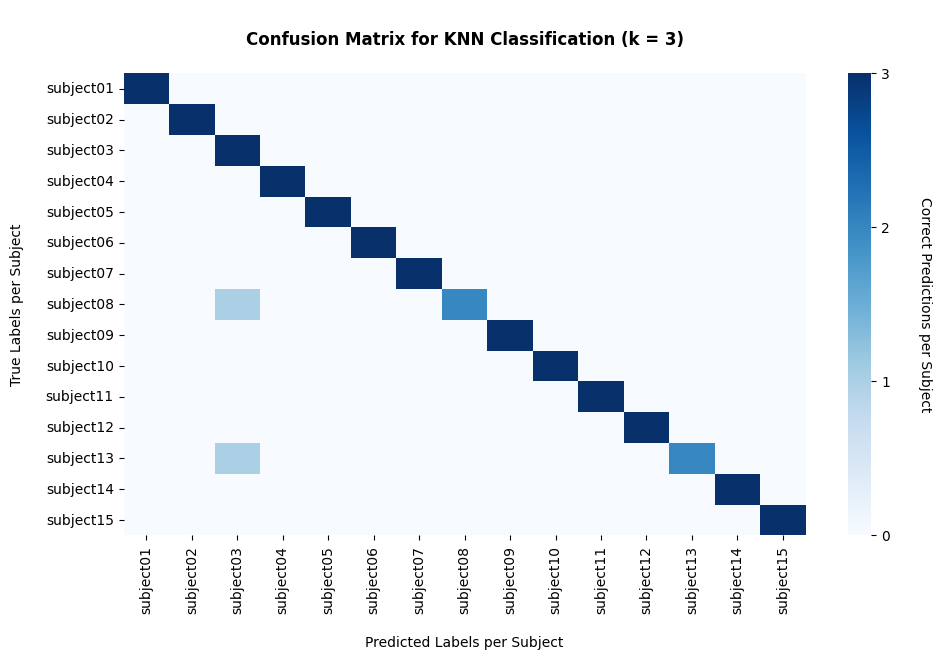

In [ ]:
from functions.knn import knn_classifier

# Number of neighbors to consider
k = 3
predictions = knn_classifier(train_reduced, train_labels, test_reduced, test_labels, k)

# Convert them to NumPy arrays if they aren’t already:
true_labels = np.array(test_labels)
pred_labels = np.array(predictions)

# Compute the confusion matrix. It will have shape (n_classes, n_classes)
cm = confusion_matrix(true_labels, pred_labels)

#Determine unique class labels for better tick labeling
classes_labels = np.unique(np.concatenate((true_labels, pred_labels)))

# Define a custom palette with soft blue tones
#custom_palette = sns.color_palette(["#ffffff", "#87CEFA", "#3A84C0", "#001f3f"], as_cmap=True)

plt.figure(figsize=(11, 6))
heatmap = sns.heatmap(cm, cmap="Blues", xticklabels=classes_labels, yticklabels=classes_labels)

# Customize the colorbar annotations
cbar = heatmap.collections[0].colorbar
# Set specific tick positions
cbar.set_ticks([0, 1, 2, 3]) 
# Labelpad is used to adjust the distance of the label from the colorbar
cbar.set_label("Correct Predictions per Subject", rotation=270, labelpad=30)

plt.xlabel('\nPredicted Labels per Subject')
plt.ylabel('True Labels per Subject\n')
plt.title(label=f"\nConfusion Matrix for KNN Classification (k = {k})\n", fontweight='bold')
plt.show()

---

## <a id="testing"></a> 4. Model testing

In [ ]:
img_check = Image.open("datasets/subject01.glasses.gif")
print(f"Size: {img_check.size}")

In [ ]:
# first we rescale the image to the original size of the training images
image_height = 243
image_width = 320
original_shape_test_images = test_arr.reshape(-1, image_height, image_width)
print(f"final_test shape: {test_arr.shape}")
print(f"test_images original shape: {original_shape_test_images.shape}")

# Determine misclassified indices
#zipping the true labels and predictions to find misclassified images
misclassified_indices = [i for i, (true, pred) in enumerate(zip(test_labels, predictions)) if true != pred]
# Print the number of misclassified images and their indices
print(f"Total misclassified images found: {len(misclassified_indices)}")
print(misclassified_indices)
# Let's plot up to 16 misclassified images (or fewer if not available)
num_to_plot = min(16, len(misclassified_indices))
# for this a plot with subplots is created
plt.figure(figsize=(12, 12))
for idx, mis_idx in enumerate(misclassified_indices[:num_to_plot]):
    plt.subplot(4, 4, idx+1)
    plt.imshow(original_shape_test_images[mis_idx], cmap='gray') # assuming grayscale images
    plt.title(f"True: {test_labels[mis_idx]}\nPredicted: {predictions[mis_idx]}")
    plt.axis('off')
#plt.subtitle("Misclassified Test Images", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

---

## <a id="accuracy"></a> 5. Accuracy evaluation

### 5.1 Which seed should we use?

In [ ]:
from functions.evaluation import preprocessing_seed

# Lets run the KNN classifier with different random seeds to see how the accuracy changes.
seeds = np.array(range(40,43))

accuracies = []

for seed in seeds:
    final_train, train_labels, final_test, test_labels = preprocessing_seed(seed)

    projection_matrix, train_reduced, explained_variance_ratio = svd_pca(final_train, n_components, verbose=False)

    test_reduced = pca_transform(final_test, projection_matrix, verbose=False)

    predictions = knn_classifier(train_reduced, train_labels, test_reduced, test_labels, k=3, verbose=False)
    accuracy = np.mean(np.array(predictions) == np.array(test_labels))
    accuracies.append(accuracy)

df_seed = pd.DataFrame({
    'Seed': seeds,
    'KNN Accuracy per seed (%)': np.array(accuracies) * 100
})

# Get the index of the highest accuracy
max_index = df_seed['KNN Accuracy per seed (%)'].idxmax()

# Extract the best seed and its accuracy
best_seed = df_seed.loc[max_index, 'Seed']
highest_acc_seed = df_seed.loc[max_index, 'KNN Accuracy per seed (%)']

plt.figure(figsize=(11, 6))
sns.lineplot(data=df_seed, x='Seed', y='KNN Accuracy per seed (%)', marker='o')
sns.set_theme(style="ticks")

plt.title("\nAccuracy of KNN Classifier with Different Random Seeds\n", fontweight='bold')
plt.scatter(best_seed, highest_acc_seed, color="red", s=25, zorder=2, 
            label=f"Best seed: {best_seed} ({highest_acc_seed:.2f}%)")
plt.xlabel("\nSeed Number")
plt.ylabel("KNN Accuracy per seed (%)\n")
plt.legend()
plt.ylim(0, 100)
plt.tight_layout()

### 5.2  Determining the best train/test data ratio

For small datasets, the results also depend on the way you choose to split the dataset. We need to use a certain amount of training images, so that the model recongnizes most of the unseen test images correctly. If no suffienct amount training data per subject is provided, KNN performs poorly, because not enough data was provided to learn, in our case to create sufficient cluster, where our images can be assigned to. Too much training data may also lead to poor results, especially for small datasets, as this can result in high variance and limited validation options.

Therefore, we use Hold-out validation to evaluate the KNN classifier performance and even more what kind of splitting is the most efficient one, based on the KNN Accuuracy with k = AMOUNT EINFÜGEN, which was evaluated beforehand in Section 5.1. Our results are shown in the follwing plot and are similar to further scientifc work. (Diebold, F.X. (2014))

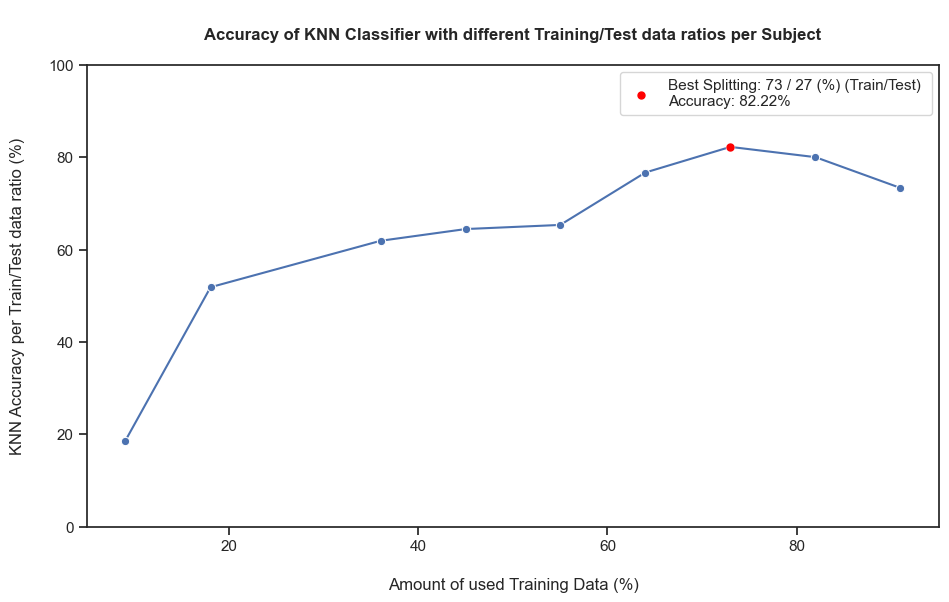

In [ ]:
from functions.evaluation import preprocessing_split_ratio

train_test_ratios = [1/11, 2/11, 4/11, 5/11, 6/11, 7/11, 8/11, 9/11, 10/11]

train_test_accuracies = []

# loop through a
for train_test_ratio in train_test_ratios:
    final_train_split, train_labels_split, final_test_split, test_labels_split = preprocessing_split_ratio(train_test_ratio)

    projection_matrix_split, train_reduced_split, explained_variance_ratio_split = svd_pca(final_train_split, n_components, verbose=False)

    test_reduced_split = pca_transform(final_test_split, projection_matrix_split, verbose=False)

    predictions_split = knn_classifier(train_reduced_split, train_labels_split, test_reduced_split, test_labels_split, k=3, verbose=False)
    accuracy_split = np.mean(np.array(predictions_split) == np.array(test_labels_split))
    train_test_accuracies.append(accuracy_split)

df_split = pd.DataFrame({
    "Amount of training data (%)": [round(r * 100) for r in train_test_ratios],
    "KNN Accuracy per Train/Test Ratio (%)": [round(a * 100, 2) for a in train_test_accuracies]
})

# Get the index of the highest accuracy
max_index_split = df_split['KNN Accuracy per Train/Test Ratio (%)'].idxmax()

# Extract the best splitting and its accuracy
best_split = df_split.loc[max_index_split, 'Amount of training data (%)']
highest_acc_split = df_split.loc[max_index_split, 'KNN Accuracy per Train/Test Ratio (%)']

plt.figure(figsize=(11, 6))
sns.lineplot(data=df_split, x="Amount of training data (%)", y="KNN Accuracy per Train/Test Ratio (%)", marker="o")
sns.set_theme(style="ticks")

plt.title("\nAccuracy of KNN Classifier with different Training/Test data ratios per Subject\n", fontweight='bold')
plt.xlabel("\nAmount of used Training Data (%)")
plt.ylabel("KNN Accuracy per Train/Test data ratio (%)\n")
plt.scatter(best_split, highest_acc_split, 
            color="red", s=25, zorder=2, 
            label=f"Best Splitting: {best_split} / {100-best_split} (%) (Train/Test) \nAccuracy: {highest_acc_split:.2f}%")
plt.ylim(0, 100)
plt.legend()
plt.show()

### 5.3.1 Accuracy vs. PC

In [ ]:
from functions.preprocessing import preprocessing
from functions.knn import knn_classifier

# How does the number of principal components affect the accuracy of the model?
pc_range = np.arange(1, 100, 1)

accuracies = []

for pc in pc_range:
    print(f"\nAmount of Principal Components: {pc}")
    final_train, train_labels, final_test, test_labels, test_arr = preprocessing()

    projection_matrix, train_reduced, explained_variance_ratio = svd_pca(final_train, pc)

    test_reduced = pca_transform(final_test, projection_matrix)

    predictions = knn_classifier(train_reduced, train_labels, test_reduced, test_labels, k=3)
    accuracy = np.mean(np.array(predictions) == np.array(test_labels))
    accuracies.append(accuracy)


# Plot the accuracies
df = pd.DataFrame({
    'Amount of Principal Components': pc_range,
    'Accuracy (%)': np.array(accuracies) * 100
})

sns.set_theme(style="whitegrid")

plt.figure(figsize=(11, 6))
sns.lineplot(data=df, x='Amount of Principal Components', y='Accuracy (%)', marker='o')
plt.title("Accuracy of KNN Classifier with Different Amounts of Principal Components")
plt.ylim(0, 100)
plt.tight_layout()

### 5.3.2 How much Variance is explained by each PC?

After evaluating the dataset splitting, we now want to find out which amount of pricipal components (PC) is the one with the highest accuracy and fast data processing. We defined a threshold of ... % to be the perfect variance. Therefore we choose .... PCs. The curve shows a horizontal asymptotic behavior. It increases exponentially in the beginning. As the number of components increases, the cumulative explained variance ratio continues to grow, but at a slower rate.

In [ ]:
projection_matrix_for_plot, train_reduced_for_plot, explained_variance_ratio_for_plot = svd_pca(final_train,100)

n_pcs_for_plot = np.arange(1, 101)  # Range of components from 1 to 100

# times 100 to convert to percentage
cumulative_variance = np.cumsum(explained_variance_ratio_for_plot*100)

# We subtract 1 from n_components because python uses 0-based indexing
highlight_n_plot_y = cumulative_variance[n_components-1]

sns.set_theme(style="ticks", font_scale=1.2)
plt.figure(figsize=(11, 6))
sns.lineplot(x=n_pcs_for_plot, y=cumulative_variance)

plt.xlabel("\nNumber of Principal Components")
plt.ylabel("Cumulative Variance Explained (%)\n")
plt.title(label="\nCumulative Variance Explained by Principal Components\n", fontweight='bold')
plt.axhline(y=highlight_n_plot_y, color='r', linestyle='--', label="Threshold")
plt.scatter(n_components, highlight_n_plot_y, color="red", s=25, zorder=2, label=f"PC {n_components} ({highlight_n_plot_y:.2f}%)")
plt.legend()

### 5.4 Finding the best k

Finding best k was performed with a dataset splitting of 70/30 as it is the way of splitting, which gave the best empiric results in other scientific paper. This is proofed in Section **HINZUFÜGEN**.

In [ ]:
# Dictionary to store accuracies for each k value.
accuracy_dict = {}

#\033[1m stands for bold;\033[3m stands for italic \033[0m resets the formatting to normal.
print(f"Evaluation of best \033[3m\033[1mk\033[0m for:")
print(f"\033[3m\033[1m{len(train_reduced)}\033[0m training images and \033[3m\033[1m{len(test_reduced)}\033[0m test images and \033[3m\033[1m{n_components}\033[0m principal components")

# loop through k values from 1 to 40, as k = 1 is not considered a good choice for KNN.
for k in range(1, 41):
    predicted_labels = knn_classifier(train_reduced, train_labels, test_reduced, test_labels, k, verbose=False)
    accuracy = np.mean(np.array(predicted_labels) == np.array(test_labels))
    # assigns the value of accuracy to the key k in the dictionary accuracy_dict.
    # This means for each value of k (the number of neighbors in KNN), you store the corresponding classification accuracy.
    accuracy_dict[k] = accuracy
    #print(f"k = {k}: Classification Accuracy = {accuracy * 100:.2f}%")	

# Identify the best k value based on the highest accuracy
best_k = max(accuracy_dict, key=accuracy_dict.get)
highest_accuracy = accuracy_dict[best_k]*100
print(f"\nBest k = {best_k} with accuracy: \033[1m{highest_accuracy:.2f}%\033[0m")

# First, sort the dictionary keys (k values) for plotting in order.
k_values = sorted(accuracy_dict.keys())
k_accuracy_values = [accuracy_dict[k]*100 for k in k_values]


sns.set_theme(style="ticks", font_scale=1.2)
plt.figure(figsize=(11, 6))
sns.lineplot(x=k_values, y=k_accuracy_values, marker='o')

plt.xlabel("\nNumber of Neighbors (k)")
plt.ylabel("KNN Classification Accuracy (%)\n")
plt.title(label="\nKNN Classification Accuracy based on Number of Neighbors k\n", fontweight='bold')
plt.scatter(best_k, highest_accuracy, color="red", s=25, zorder=2, label=f"Highest Accuracy k = {best_k} ({highest_accuracy:.2f}%)")
plt.legend()

---

## <a id="further-analysis"></a> 6. Further analysis

In [ ]:
# for MacOS users, the path separator is a forward slash, please uncomment the following line:
# %run functions/furtheranalysis.py

%run functions\furtheranalysis.py